<a href="https://colab.research.google.com/github/MNiharika20/Niharika2098/blob/main/Project_Churn_Prediction_for_StreamWorks_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Week 3 Project

Successfully loaded 'streamworks_user_data.csv'.

Data head:
   user_id   age  gender signup_date last_active_date  country  \
0   1001.0  56.0   Other  02/04/2025       13/07/2025   France   
1   1002.0  69.0    Male  02/01/2023       13/07/2025    India   
2   1003.0  46.0    Male  21/08/2022       13/07/2025       UK   
3   1004.0  32.0   Other  14/09/2023       13/07/2025  Germany   
4   1005.0  60.0  Female  29/07/2023       13/07/2025    India   

  subscription_type  average_watch_hours  mobile_app_usage_pct  \
0          Standard                 42.6                  77.4   
1             Basic                 65.3                  98.0   
2           Premium                 40.1                  47.8   
3           Premium                  5.8                  53.2   
4          Standard                 32.7                  16.8   

   complaints_raised received_promotions referred_by_friend  is_churned  \
0                1.0                  No                 No         1.

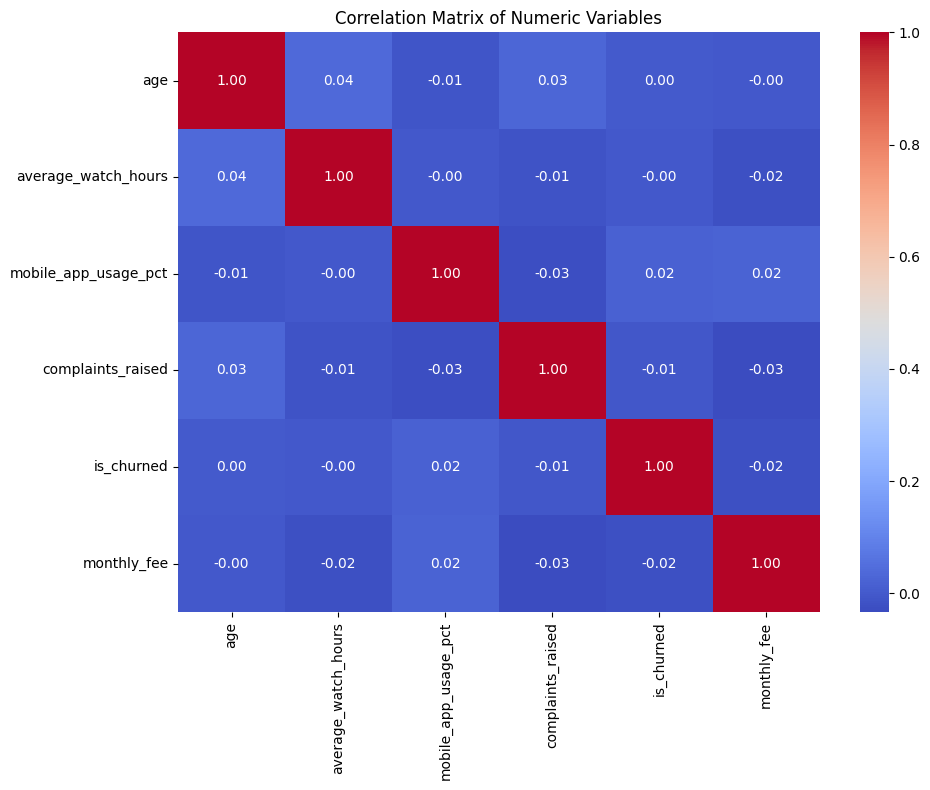

In [ ]:
# Load the dataset
file_name = 'streamworks_user_data.csv'

try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")

    # Task 1: Load & Explore the Data
    print("\nData head:")
    print(df.head())
    print("\nData info:")
    df.info()
    print("\nData describe:")
    print(df.describe())
    print("\nMissing values:")
    print(df.isnull().sum())

    # Create a correlation matrix and heatmap for numeric variables
    # Exclude user_id as it's an identifier, not a feature
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation_matrix = df[numeric_cols].drop(columns=['user_id']).corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    print("Correlation heatmap saved as 'correlation_heatmap.png'.")

    # Save the DataFrame to a CSV file to be accessible for the next steps.
    df.to_csv('streamworks_user_data_processed.csv', index=False)
    print("Processed data saved to 'streamworks_user_data_processed.csv'.")

except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# --- 1. Fill or drop missing values, depending on context ---
# First, let's look at the missing values again
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# We will drop rows with missing values in columns that are critical for our analysis
# and only have a few missing entries.
df.dropna(subset=['user_id', 'age', 'gender', 'country', 'subscription_type', 'is_churned'], inplace=True)

# For the 'monthly_fee' column, which has many missing values,
# we will impute them based on the median fee for each subscription type.
# This prevents losing a large amount of data.
fee_imputation = df.groupby('subscription_type')['monthly_fee'].median().to_dict()
df['monthly_fee'] = df.apply(
    lambda row: fee_imputation.get(row['subscription_type'], row['monthly_fee'])
    if pd.isna(row['monthly_fee']) else row['monthly_fee'],
    axis=1
)

# --- 2. Convert date columns and create new features ---
# Convert the 'signup_date' and 'last_active_date' columns to datetime objects.
# The format parameter is crucial for correct parsing (DD/MM/YYYY).
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%d/%m/%Y')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], format='%d/%m/%Y')

# Create 'tenure_days' feature
# Calculate the difference between the dates and extract the number of days.
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days

# Create 'is_loyal' feature
# This is a binary feature (0 or 1) based on tenure.
df['is_loyal'] = (df['tenure_days'] > 180).astype(int)

# --- 3. Encode categorical features ---
# Use one-hot encoding (get_dummies) to convert categorical text data into numerical columns.
# This is required for most machine learning models.
categorical_cols = ['gender', 'country', 'subscription_type', 'received_promotions', 'referred_by_friend']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# drop_first=True helps prevent multicollinearity by dropping the first category in each column.

# Final check of the cleaned and engineered DataFrame
print("\nDataFrame info after cleaning and feature engineering:")
df.info()

# Save the final cleaned and engineered dataset to a new CSV file
# This allows you to easily load this prepared data for later tasks.
df.to_csv('streamworks_user_data_cleaned.csv', index=False)
print("\nCleaned and engineered data saved to 'streamworks_user_data_cleaned.csv'.")









Missing values before cleaning:
user_id                   2
age                       3
gender                    1
signup_date               2
last_active_date          2
country                   3
subscription_type         3
average_watch_hours       4
mobile_app_usage_pct      2
complaints_raised         3
received_promotions       3
referred_by_friend        3
is_churned                1
monthly_fee             145
dtype: int64

DataFrame info after cleaning and feature engineering:
<class 'pandas.core.frame.DataFrame'>
Index: 1487 entries, 0 to 1499
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     1487 non-null   float64       
 1   age                         1487 non-null   float64       
 2   signup_date                 1485 non-null   datetime64[ns]
 3   last_active_date            1486 non-null   datetime64[ns]
 4   average_watch_h

In [ ]:
# --- Feature Engineering ---

# Create 'watch_per_fee_ratio'
# This feature measures the user's engagement relative to the cost of their subscription.
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee']

# Create 'heavy_mobile_user'
# This is a binary feature (0 or 1) indicating high mobile usage.
# A reasonable threshold is 75%, as it represents a high percentage of viewing time.
df['heavy_mobile_user'] = (df['mobile_app_usage_pct'] >= 75).astype(int)

# You've already done encoding in the previous step, which is part of feature engineering.
# The `tenure_days` and `is_loyal` features were also created earlier.

# You can also consider transformations, like log transformation, for skewed numerical features
# (e.g., 'complaints_raised' or 'tenure_days') if they are not normally distributed.
# For example:
# df['log_complaints'] = np.log1p(df['complaints_raised']) # log1p handles zeros

# To demonstrate the new features, let's look at the DataFrame's info again.
print("\nDataFrame info after creating new features:")
df.info()

# Save the final cleaned and engineered dataset to a new CSV file
# This file is now ready for statistical analysis and modeling.
df.to_csv('streamworks_user_data_final.csv', index=False)
print("\nFinal engineered data saved to 'streamworks_user_data_final.csv'.")









DataFrame info after creating new features:
<class 'pandas.core.frame.DataFrame'>
Index: 1487 entries, 0 to 1499
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     1487 non-null   float64       
 1   age                         1487 non-null   float64       
 2   signup_date                 1485 non-null   datetime64[ns]
 3   last_active_date            1486 non-null   datetime64[ns]
 4   average_watch_hours         1485 non-null   float64       
 5   mobile_app_usage_pct        1485 non-null   float64       
 6   complaints_raised           1485 non-null   float64       
 7   is_churned                  1487 non-null   float64       
 8   monthly_fee                 1487 non-null   float64       
 9   tenure_days                 1484 non-null   float64       
 10  is_loyal                    1487 non-null   int64         
 11  gender_Male     

Successfully loaded 'streamworks_user_data_final.csv'.

--- Chi-square Test Results ---

Chi-square test for gender_Male vs. is_churned:
Contingency Table:
is_churned   0.0  1.0
gender_Male          
False        763  242
True         378  104
Chi2: 1.0071, P-value: 0.3156
Result: No significant relationship (p >= 0.05).

Chi-square test for gender_Other vs. is_churned:
Contingency Table:
is_churned    0.0  1.0
gender_Other          
False         749  236
True          392  110
Chi2: 0.6700, P-value: 0.4131
Result: No significant relationship (p >= 0.05).

Chi-square test for received_promotions_Yes vs. is_churned:
Contingency Table:
is_churned               0.0  1.0
received_promotions_Yes          
False                    569  189
True                     572  157
Chi2: 2.2162, P-value: 0.1366
Result: No significant relationship (p >= 0.05).

Chi-square test for referred_by_friend_Yes vs. is_churned:
Contingency Table:
is_churned              0.0  1.0
referred_by_friend_Yes        

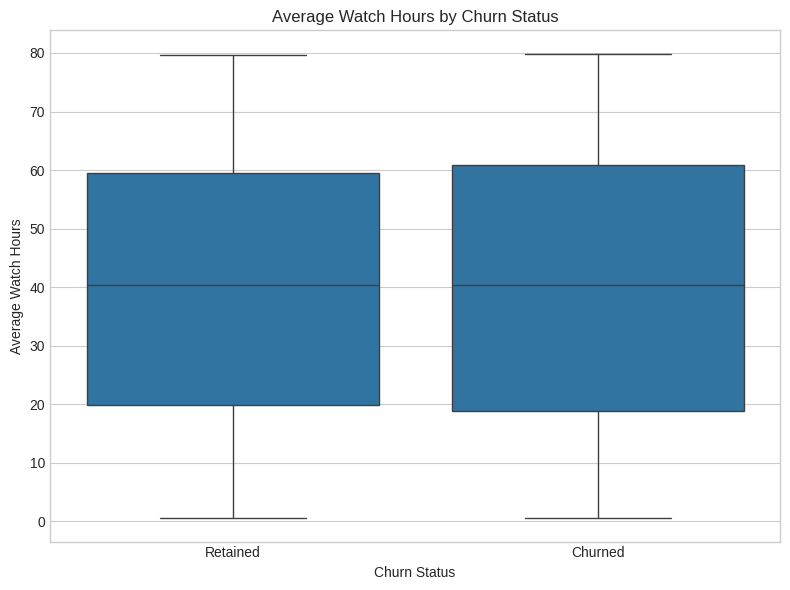

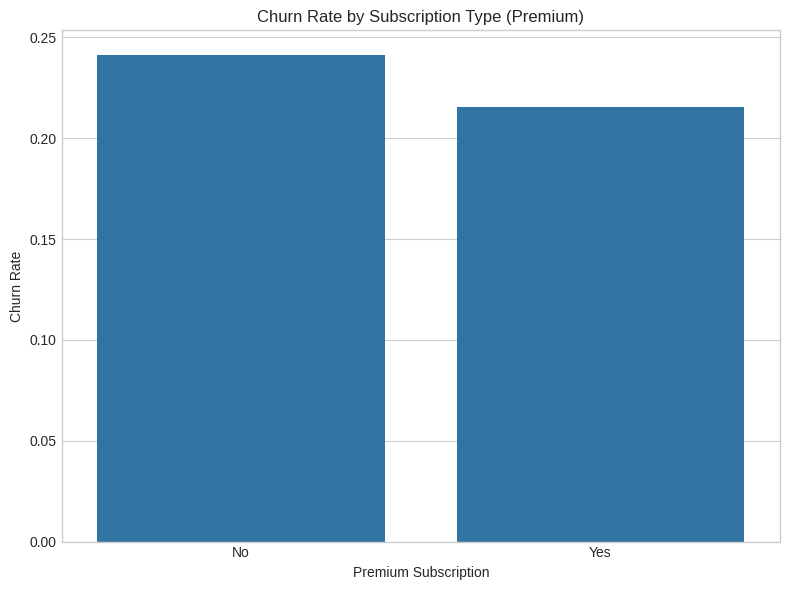

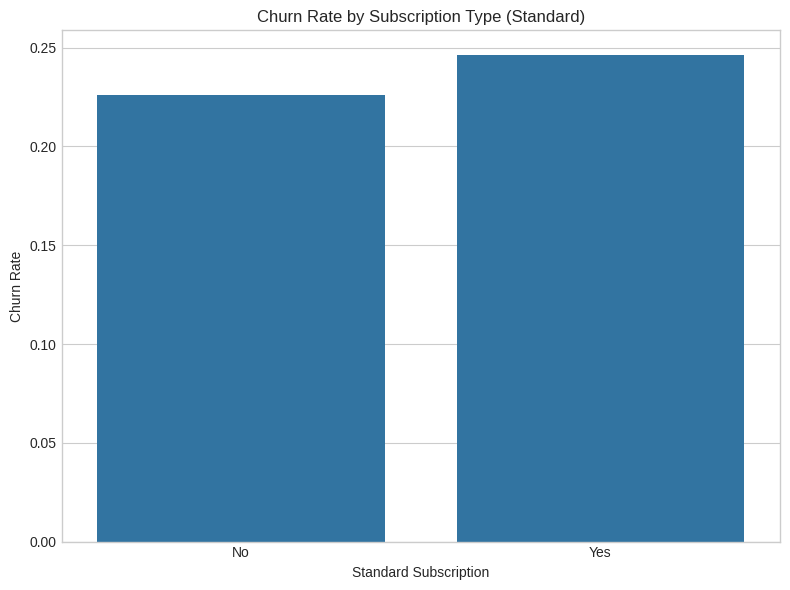

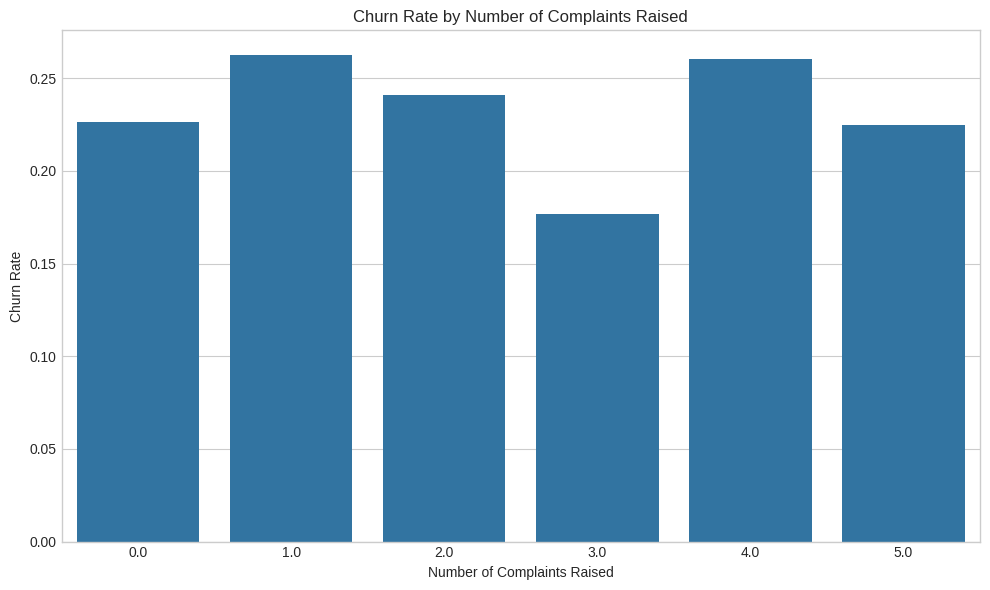

In [ ]:
# Statistical Analysis & Insights


# Load the cleaned and engineered dataset
file_name_engineered = 'streamworks_user_data_final.csv'


try:
    df = pd.read_csv(file_name_engineered)

    print(f"Successfully loaded '{file_name_engineered}'.")

except FileNotFoundError:
    print(f"Error: A required file was not found.")
    exit()

# Task 4: Statistical Analysis & Insights

# Chi-square tests for churn and categorical variables
print("\n--- Chi-square Test Results ---")
chi2_vars = ['gender_Male', 'gender_Other', 'received_promotions_Yes', 'referred_by_friend_Yes']

for var in chi2_vars:
    contingency_table = pd.crosstab(df[var], df['is_churned'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {var} vs. is_churned:")
    print(f"Contingency Table:\n{contingency_table}")
    print(f"Chi2: {chi2:.4f}, P-value: {p:.4f}")
    if p < 0.05:
        print(f"Result: Significant relationship (p < 0.05).")
    else:
        print(f"Result: No significant relationship (p >= 0.05).")

# T-test for average_watch_hours between churned and retained users
print("\n--- T-test Results ---")
churned_watch_hours = df[df['is_churned'] == 1]['average_watch_hours']
retained_watch_hours = df[df['is_churned'] == 0]['average_watch_hours']

t_stat, p_value = ttest_ind(churned_watch_hours, retained_watch_hours, equal_var=False, nan_policy='omit')
print(f"T-test for average_watch_hours (churned vs. retained):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant difference in average watch hours (p < 0.05).")
else:
    print("Result: No significant difference in average watch hours (p >= 0.05).")

# Visualizations
print("\n--- Generating Visualizations ---")
plt.style.use('seaborn-v0_8-whitegrid')

# Boxplot for average_watch_hours
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_churned', y='average_watch_hours', data=df)
plt.title('Average Watch Hours by Churn Status')
plt.xticks([0, 1], ['Retained', 'Churned'])
plt.xlabel('Churn Status')
plt.ylabel('Average Watch Hours')
plt.tight_layout()
plt.savefig('watch_hours_boxplot.png')
print("Boxplot of average watch hours saved as 'watch_hours_boxplot.png'.")

# Bar plot for churn rate by subscription type
plt.figure(figsize=(8, 6))
sns.barplot(x='subscription_type_Premium', y='is_churned', data=df.groupby('subscription_type_Premium')['is_churned'].mean().reset_index())
plt.title('Churn Rate by Subscription Type (Premium)')
plt.xlabel('Premium Subscription')
plt.ylabel('Churn Rate')
plt.xticks([0,1], ['No', 'Yes'])
plt.tight_layout()
plt.savefig('churn_rate_by_subscription_premium.png')
print("Bar plot of churn rate by subscription type saved as 'churn_rate_by_subscription_premium.png'.")

plt.figure(figsize=(8, 6))
sns.barplot(x='subscription_type_Standard', y='is_churned', data=df.groupby('subscription_type_Standard')['is_churned'].mean().reset_index())
plt.title('Churn Rate by Subscription Type (Standard)')
plt.xlabel('Standard Subscription')
plt.ylabel('Churn Rate')
plt.xticks([0,1], ['No', 'Yes'])
plt.tight_layout()
plt.savefig('churn_rate_by_subscription_standard.png')
print("Bar plot of churn rate by subscription type saved as 'churn_rate_by_subscription_standard.png'.")


# Bar plot for churn rate by complaints raised
plt.figure(figsize=(10, 6))
sns.barplot(x='complaints_raised', y='is_churned', data=df.groupby('complaints_raised')['is_churned'].mean().reset_index())
plt.title('Churn Rate by Number of Complaints Raised')
plt.xlabel('Number of Complaints Raised')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.savefig('churn_rate_by_complaints.png')
print("Bar plot of churn rate by complaints saved as 'churn_rate_by_complaints.png.")

Successfully loaded 'streamworks_user_data_final.csv'.

--- Logistic Regression Model ---
Accuracy: 0.7685
Confusion Matrix:
[[229   0]
 [ 69   0]]
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ROC curve saved as 'roc_curve.png'.

Top 5 Churn Predictors (Logistic Regression):
                       Feature  Coefficient  Abs_Coefficient
12   subscription_type_Premium    -0.337055         0.337055
3                  monthly_fee     0.270814         0.270814
6                 gender_Other    -0.101069         0.101069
1         mobile_app_usage_pct     0.097380         0.097380
13  subscription_type_Standard    -0.094780         0.094780

--- Linear Regression Model ---
R-squared (R2) score: -0.0185
Root Mean Squared Error (RMSE): 22.9244
Residuals plot saved as 'residuals_plot.png'.

Top 5 Watch Hours Predictors (Linear Regression):
              Feature  Coefficient  Abs_Coefficient
6         gender_Male     1.450354         1.450354
17  heavy_mobile_user    -1.254503         1.254503
8      country_France    -1.016922         1.016922
11         country_UK     0.887988         0.887988
7        gender_Other     0.800802         0.800802


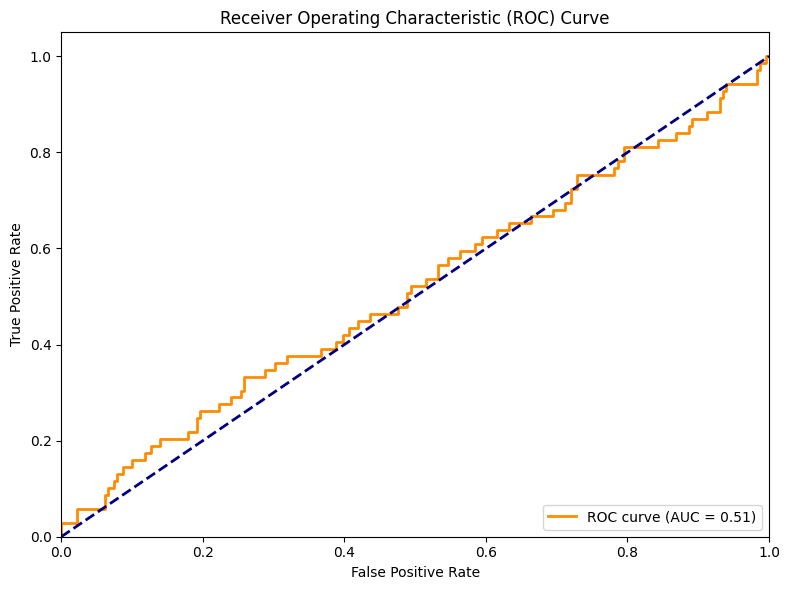

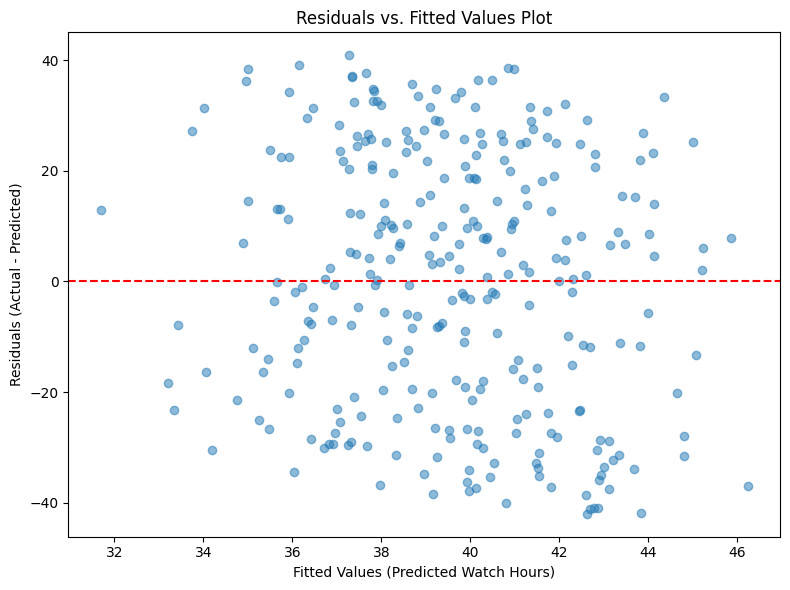

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

# Load the cleaned and engineered dataset
file_name = 'streamworks_user_data_final.csv'
try:
    df = pd.read_csv(file_name)
    print(f"Successfully loaded '{file_name}'.")
except FileNotFoundError:
    print(f"Error: The file '{file_name}' was not found.")
    exit()

# Drop unnecessary columns before modeling
df = df.drop(columns=['user_id', 'signup_date', 'last_active_date'])

# --- Task 5: Predictive Modelling ---

# Part A: Logistic Regression for Churn Prediction

print("\n--- Logistic Regression Model ---")
# Define features and target
X = df.drop(columns=['is_churned', 'average_watch_hours', 'watch_per_fee_ratio', 'is_loyal'])
y = df['is_churned']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Impute missing values using the median
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
y_pred_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
accuracy = log_reg.score(X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('roc_curve.png')
print("ROC curve saved as 'roc_curve.png'.")

# Interpret coefficients
# Need to get feature names back after imputation and scaling
feature_names = X.columns
coefficients_lr = pd.DataFrame({'Feature': feature_names, 'Coefficient': log_reg.coef_[0], 'Abs_Coefficient': np.abs(log_reg.coef_[0])})
coefficients_lr = coefficients_lr.sort_values(by='Abs_Coefficient', ascending=False)
print("\nTop 5 Churn Predictors (Logistic Regression):")
print(coefficients_lr.head(5))


# Part B: Linear Regression for Watch Hours Prediction
print("\n--- Linear Regression Model ---")

# Define features and target
X_lin = df.drop(columns=['average_watch_hours', 'is_churned', 'watch_per_fee_ratio'])
y_lin = df['average_watch_hours']

# Split data
X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(X_lin, y_lin, test_size=0.2, random_state=42)

# Handle missing values in the target variable for the training set
train_data = pd.DataFrame(X_lin_train, columns=X_lin.columns)
train_data['average_watch_hours'] = y_lin_train.reset_index(drop=True)
train_data.dropna(subset=['average_watch_hours'], inplace=True)
X_lin_train = train_data.drop(columns=['average_watch_hours'])
y_lin_train = train_data['average_watch_hours']

# Impute missing values using the median for linear regression features
imputer_lin = SimpleImputer(strategy='median')
X_lin_train = imputer_lin.fit_transform(X_lin_train)
X_lin_test = imputer_lin.transform(X_lin_test)

# Scale features
scaler_lin = StandardScaler()
X_lin_train = scaler_lin.fit_transform(X_lin_train)
X_lin_test = scaler_lin.transform(X_lin_test)

# Train the model
lin_reg = LinearRegression()
lin_reg.fit(X_lin_train, y_lin_train)

# Predict and evaluate
y_pred_lin = lin_reg.predict(X_lin_test)

# Evaluation Metrics
r2 = r2_score(y_lin_test, y_pred_lin)
rmse = np.sqrt(mean_squared_error(y_lin_test, y_pred_lin))

print(f"R-squared (R2) score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Residual plot
residuals = y_lin_test - y_pred_lin
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_lin, residuals, alpha=0.5)
plt.title('Residuals vs. Fitted Values Plot')
plt.xlabel('Fitted Values (Predicted Watch Hours)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.savefig('residuals_plot.png')
print("Residuals plot saved as 'residuals_plot.png'.")

# Interpret coefficients
# Need to get feature names back after imputation and scaling
feature_names_lin = X_lin.columns
coefficients_lin = pd.DataFrame({'Feature': feature_names_lin, 'Coefficient': lin_reg.coef_, 'Abs_Coefficient': np.abs(lin_reg.coef_)})
coefficients_lin = coefficients_lin.sort_values(by='Abs_Coefficient', ascending=False)
print("\nTop 5 Watch Hours Predictors (Linear Regression):")
print(coefficients_lin.head(5))